In [1]:
#pip install xgboost

In [2]:
#pip install graphviz

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import graphviz
import warnings
warnings.filterwarnings('ignore')

# Regression with XGBoost

In [4]:
url = 'https://assets.datacamp.com/production/repositories/943/datasets/4dbcaee889ef06fb0763e4a8652a4c1f268359b2/ames_housing_trimmed_processed.csv'
ames_df = pd.read_csv(url)

In [5]:
ames_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,1,1647,0,0,...,0,0,0,0,1,0,0,0,1,175000
1456,20,85.0,13175,6,6,1978,1,2073,1,0,...,0,1,0,0,0,0,0,0,1,210000
1457,70,66.0,9042,7,9,1941,1,2340,0,0,...,0,0,0,0,1,0,0,0,1,266500
1458,20,68.0,9717,5,6,1950,1,1078,1,0,...,0,1,0,0,0,0,0,0,1,142125


In [6]:
X = ames_df.drop('SalePrice', axis=1)
y = ames_df['SalePrice']

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.metrics import mean_squared_error

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(seed = 123, objective = 'reg:squarederror', n_estimators=10)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 28106.463641


### Regression Cross Validation

In [9]:
# Evaluating Model Quality with Cross Validation:

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

print('\n')

# Extract and print final boosting round metric
print('Test Set RMSE:', (cv_results["test-rmse-mean"]).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    141767.533478      429.451090   142980.434934    1193.795492
1    102832.547530      322.472076   104891.395389    1223.157368
2     75872.617039      266.474211    79478.938743    1601.345019
3     57245.651780      273.624239    62411.921348    2220.150063
4     44401.298519      316.423620    51348.279619    2963.378136


Test Set RMSE: 4    51348.279619
Name: test-rmse-mean, dtype: float64


### Hyperparameter Tuning Regularization - Manually

In [10]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2          rmse
0    1  52275.357003
1   10  57746.063828
2  100  76624.627811


### XGBoost Feature Importance

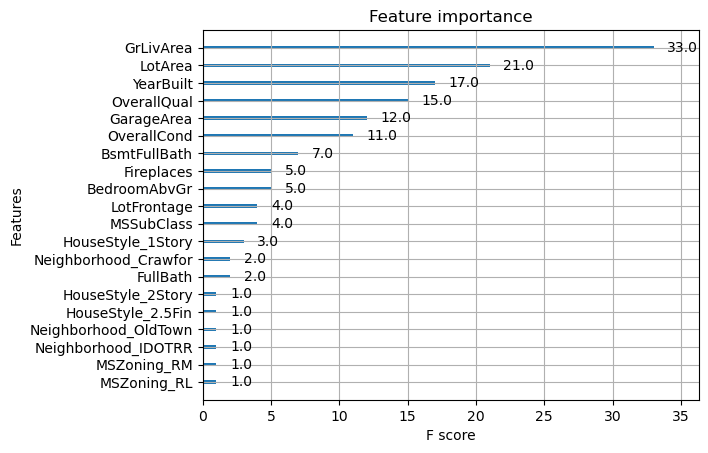

In [11]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective": "reg:squarederror", "max_depth": 4}

# Train the model: xg_reg
xg_reg = xgb.train(dtrain =housing_dmatrix, params = params, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

# Hyperparameter Tuning XGBoost Model

## Grid Search CV

In [12]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': np.arange(0, 1.2, 0.4),
    'subsample': np.arange(0, 1.2, 0.4),
    'eta': [0.001, 0.01, 0.1, 0.3, 0.5],
    'n_estimators': [50],
    'max_depth': np.arange(2, 6)
}

# Gamma, Lambda, Alpha are other Regularization Parameters to Tune
# https://xgboost.readthedocs.io/en/stable/parameter.html

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 4, verbose = 1)


# Fit grid_mse to the data
grid_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Best parameters found:  {'colsample_bytree': 0.4, 'eta': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Lowest RMSE found:  29457.54076738117


## Random Search CV

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'colsample_bytree': np.arange(0, 1.2, 0.4),
    'eta': [0.001, 0.01, 0.1],
    'n_estimators': [50],
    'max_depth': np.arange(2, 6)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator = gbm, param_distributions = gbm_param_grid, scoring = "neg_mean_squared_error", n_iter = 5, cv = 4, verbose = 1)


# Fit randomized_mse to the data
randomized_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 50, 'max_depth': 4, 'eta': 0.1, 'colsample_bytree': 0.4}
Lowest RMSE found:  30736.6076099509


Don't include subsample in RandomizedSearchCV will mess things up.

# XGBoost in Pipelines

### Pipeline & Cross Validation

In [14]:
# Import necessary modules
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Fill LotFrontage missing values with 0
X.LotFrontage = X.LotFrontage.fillna(0)

# Setup the pipeline steps: steps
steps = [("ohe_onestep", DictVectorizer(sparse=False)),
         ("xgb_model", xgb.XGBRegressor(objective="reg:squarederror"))]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

# Cross-validate the model
cross_val_scores = cross_val_score(xgb_pipeline, X.to_dict("records"), y, cv = 10, scoring = "neg_mean_squared_error")

# Print the 10-fold RMSE
print("10-fold RMSE: ", np.mean(np.sqrt(np.abs(cross_val_scores))))

10-fold RMSE:  28540.921741027723


## Pipeline & Hyperparameter Tuning

In [23]:
# Create the parameter grid

xgb_pipeline = Pipeline([
    ('xgb_model', xgb.XGBRegressor())
])


gbm_param_grid = {
    'xgb_model__colsample_bytree': np.arange(0, 1.2, 0.4),
    'xgb_model__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5],
    'xgb_model__n_estimators': [50],
    'xgb_model__max_depth': np.arange(2, 6)
}

# Perform RandomizedSearchCV
randomized_mse = RandomizedSearchCV(estimator = xgb_pipeline, param_distributions = gbm_param_grid, cv = 5, n_iter = 2, scoring = 'neg_mean_squared_error', verbose = 1)

# Fit the estimator

randomized_mse.fit(X, y)

print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found:  {'xgb_model__n_estimators': 50, 'xgb_model__max_depth': 4, 'xgb_model__learning_rate': 0.01, 'xgb_model__colsample_bytree': 0.8}
Lowest RMSE found:  124729.31051592568
